<a href="https://colab.research.google.com/github/MhmDSmdi/Relation-Aware-Joint-Entity-Detection-and-Relation-Extraction/blob/main/src/LSTM_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Required Libraries

In [1]:
!pip3 install -q -U keras-tuner
!pip3 install tensorflow-addons[tensorflow]
!pip3 install pickle5

     |████████████████████████████████| 135 kB 7.9 MB/s 
     |████████████████████████████████| 1.6 MB 60.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 6.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 8.4 MB/s 


In [2]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 8s (53.7 MB/s)
(Reading database ... 155676 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155654 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+c

## Import Required Libraries

In [3]:
import os
import re
import json
import random
import warnings
from collections import defaultdict
from collections import Counter
from itertools import chain

import cv2
from PIL import Image, ImageOps
import math


import pickle5 as pickle

import numpy as np
np.random.seed(2022)
import pandas as pd


import matplotlib
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

import tensorflow as tf
import keras_tuner as kt
import keras.backend as K
from keras.engine import data_adapter
import tensorflow_addons as tfa
from tensorflow import keras 
from keras.metrics import categorical_accuracy, AUC
from sklearn.metrics import (accuracy_score, f1_score,
                             precision_score, recall_score,
                             classification_report,
                             confusion_matrix
                            )

In [4]:
tf.__version__

'2.8.2'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import sys
sys.path.append('/content/drive/MyDrive/joint_level_generation_translation/')

In [7]:
%cd "drive/MyDrive/joint_level_generation_translation/"

/content/drive/MyDrive/joint_level_generation_translation


## Load Config

In [8]:
from src.config.config_loader import load_config 
config = load_config("src/config/config.yaml")

# retrieve list of games from config
game_keys = list(config["datasets"].keys())

In [131]:
TEST_GAME = "smb" #@param
CHANNELS = 3 #@param
WINDOW_SIZE = 5 #@param

## Load Datasets

In [132]:
all_datasets = {}

for game_key in game_keys:
    data = dict()
    print(f"Loading {game_key}...")
    with open(f"./data/{game_key}/dataset.pickle", "rb") as fh:
        data = pickle.load(fh) 
        all_datasets[game_key] = data

Loading kid_icarus...
Loading megaman...
Loading smb...
Loading zelda...
Loading load_runner...


## Data Analysis

kid_icarus
megaman
smb
zelda
load_runner


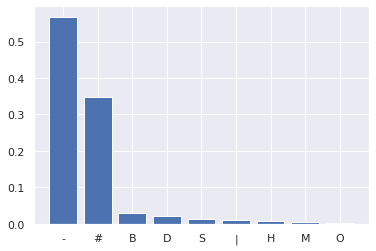

In [133]:
# Data Analysis
with open('./data/id_to_idx.json') as json_file:
    enc_map: dict = json.load(json_file)["tiles"]
    reversed_enc_map = dict((v,k) for k,v in enc_map.items())

frequencies = defaultdict(lambda: defaultdict(lambda:0))
cnt = 0
for game_key, data in all_datasets.items():
  print(game_key)
  for frame_name, frame_data in data.items():
    cnt += 1
    ans = Counter([x for sublist in frame_data for x in sublist])
    frequencies =  dict(Counter(frequencies)+Counter(ans))

freqs_01 = {}
sum_vals = 0
for value in frequencies.values():
  sum_vals += value
  
for key, value in frequencies.items():
  freqs_01[reversed_enc_map[key]] = value / sum_vals

srt = (dict(sorted(freqs_01.items(), reverse=True, key=lambda item: item[1])))
plt.bar(*zip(*srt.items()))
plt.show()

In [134]:
print(srt)

{'-': 0.5680628640509946, '#': 0.3468209693372898, 'B': 0.028687548082206835, 'D': 0.021419496647983295, 'S': 0.012915705022529948, '|': 0.009224749972524452, 'H': 0.006868886690845148, 'M': 0.003901527640400044, 'O': 0.002098252555225849}


## Load Images

In [135]:
""" load images """
images = dict()
for game_key in game_keys:
  # directory = f"./data/{game_key}/cropped_resized"
  directory = f"./data/{game_key}/cropped"
  print(f"Processing {game_key} data...")
  for file in os.listdir(directory):
      filename = os.fsdecode(file)
      if filename.endswith(".png"):
        img_bgr = cv2.imread(os.path.join(directory, filename))
        if CHANNELS == 3:
          img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        else:
          img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        img_rgb = cv2.resize(img_rgb, (75, 50)) 

        image = np.asarray(img_rgb)
        to_save = image.astype(np.uint8)
        images[f"{game_key}-{filename}"] = to_save
print(f"Number of images in the dataset: {len(images)}")

Processing kid_icarus data...
Processing megaman data...
Processing smb data...
Processing zelda data...
Processing load_runner data...
Number of images in the dataset: 15175


In [136]:
limit = 2000
valid_start_ends = {}
for game_key in all_datasets.keys():
  if game_key != TEST_GAME:
    game_dataset = all_datasets[game_key]
    if len(game_dataset) < 2000:
      start = int(0.9* len(game_dataset))
      end = len(game_dataset)
    else:
      start = 2001 
      end = min(len(game_dataset), 2200)
    
    valid_start_ends[game_key] = (start, end)

print(valid_start_ends)

{'kid_icarus': (2001, 2145), 'megaman': (2001, 2195), 'zelda': (2001, 2200), 'load_runner': (540, 600)}


## Train/Validation/Test Splitting

In [137]:
num_classes = len(list(enc_map.keys()))

In [138]:
def sliding_window(seq, window_size, real_X, real_names=None, frame_names=None):
  result, frames = [], []
  
  for i in range(len(seq) - window_size + 1):
      result += [seq[i: i + window_size]]
      if frame_names:
        frames += [frame_names[i: i + window_size]]

  if frame_names:
    real_X += result
    real_names += frames
  else:
    real_X += result
  
  return real_X, real_names

In [139]:
from numpy.lib.stride_tricks import sliding_window_view

X_train = []
y_train = []
X_train_frame_names = []

X_valid = []
y_valid = []
X_valid_frame_names = []

X_test = []
y_test = []
X_test_frame_names = []

def convert_to_float_np_arr(list):
  return np.asarray(list, dtype=np.double)

def convert_to_int_np_arr(list):
  return np.asarray(list, dtype=np.uint8)

for game_key in game_keys:
  game_dataset = all_datasets[game_key]
  num_of_game_frames = len(game_dataset)
  if game_key != TEST_GAME:
    start, end = valid_start_ends[game_key]
  
  counter = -1
  X_test_holder = []
  X_test_fname_holder = []
  y_test_holder = []

  X_train_holder = []
  X_train_fname_holder = []
  y_train_holder = []

  X_valid_holder = []
  X_valid_fname_holder = []
  y_valid_holder = []

  for image_name in sorted(game_dataset.keys()):
    counter += 1
    if TEST_GAME in image_name:
      X_test_holder.append(images[image_name])
      y_test_holder.append(game_dataset[image_name])
      X_test_fname_holder.append(image_name)
    elif counter < start:
      X_train_holder.append(images[image_name])
      y_train_holder.append(game_dataset[image_name])
      X_train_fname_holder.append(image_name)
    elif counter < end:
      X_valid_holder.append(images[image_name])
      y_valid_holder.append(game_dataset[image_name])
      X_valid_fname_holder.append(image_name)

  X_train, X_train_frame_names = sliding_window(X_train_holder, WINDOW_SIZE, X_train, X_train_frame_names,  X_train_fname_holder)
  X_valid, X_valid_frame_names = sliding_window(X_valid_holder, WINDOW_SIZE, X_valid, X_valid_frame_names, X_valid_fname_holder)
  X_test, X_test_frame_names = sliding_window(X_test_holder, WINDOW_SIZE, X_test, X_test_frame_names, X_test_fname_holder)

  y_train, _ = sliding_window(y_train_holder, WINDOW_SIZE, y_train)
  y_valid, _ = sliding_window(y_valid_holder, WINDOW_SIZE, y_valid)
  y_test, _ = sliding_window(y_test_holder, WINDOW_SIZE, y_test)


DIVIDE_BY = 255

X_train = convert_to_float_np_arr(X_train) / DIVIDE_BY
y_train_numerical = convert_to_int_np_arr(y_train)
y_train = keras.utils.to_categorical(
    y_train_numerical-1, num_classes = num_classes
)

X_valid = convert_to_float_np_arr(X_valid) / DIVIDE_BY
y_valid_numerical = convert_to_int_np_arr(y_valid)
y_valid = keras.utils.to_categorical(
    y_valid_numerical-1, num_classes = num_classes
)

X_test = convert_to_float_np_arr(X_test) / DIVIDE_BY
y_test_numerical = convert_to_int_np_arr(y_test)
y_test = keras.utils.to_categorical(
    y_test_numerical-1, num_classes = num_classes
)

print(f"Number of images in the dataset: {len(images)}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_valid: {X_valid.shape}")
print(f"Shape of y_valid: {y_valid.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Number of images in the dataset: 15175
Shape of X_train: (6527, 5, 50, 75, 3)
Shape of y_train: (6527, 5, 10, 15, 9)
Shape of X_valid: (581, 5, 50, 75, 3)
Shape of y_valid: (581, 5, 10, 15, 9)
Shape of X_test: (1411, 5, 50, 75, 3)
Shape of y_test: (1411, 5, 10, 15, 9)


## Compute Sample **Weights**

In [140]:
weight_mapping = {}

# for key, value in frequencies.items():
#   weight_mapping[key]= max(round((1/(value/sum_vals))/3), 1)

weight_mapping = {
    1: 64,
    2: 1,
    3: 8,
    4: 16,
    5: 32,
    9: 64,
    8: 8,
    7: 8,
    12: 4,
    6: 4,
}
print(weight_mapping)
sample_weight = np.ones(y_train_numerical.shape)
print(sample_weight.shape)

def custom_map(source, mapping):
  out = []
  for instance in source:
    ins_out = []
    for line in instance:
      ins_out.append(list(map(mapping.get, line)))
    out.append(ins_out)
  return out

for (index, instance) in enumerate(y_train_numerical):
    sample_weight[index] = custom_map(instance, weight_mapping)

print(" y_train shape: ", y_train.shape, " sample_weights shapes: ", sample_weight.shape)

{1: 64, 2: 1, 3: 8, 4: 16, 5: 32, 9: 64, 8: 8, 7: 8, 12: 4, 6: 4}
(6527, 5, 10, 15)
 y_train shape:  (6527, 5, 10, 15, 9)  sample_weights shapes:  (6527, 5, 10, 15)


### Visualize Random Images From the Dataset

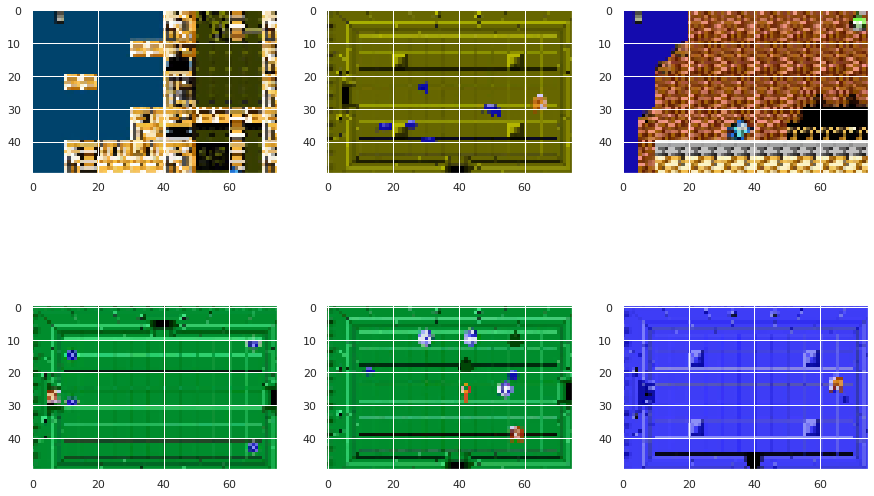

In [141]:
from IPython.display import display # to display images

fig = plt.figure( figsize=(15, 10))
for i in range(6):
  sample_image = random.choice(list(X_train))[0]
  ax1 = fig.add_subplot(2 , 3, i+1)
  ax1.imshow(sample_image, cmap='gray')

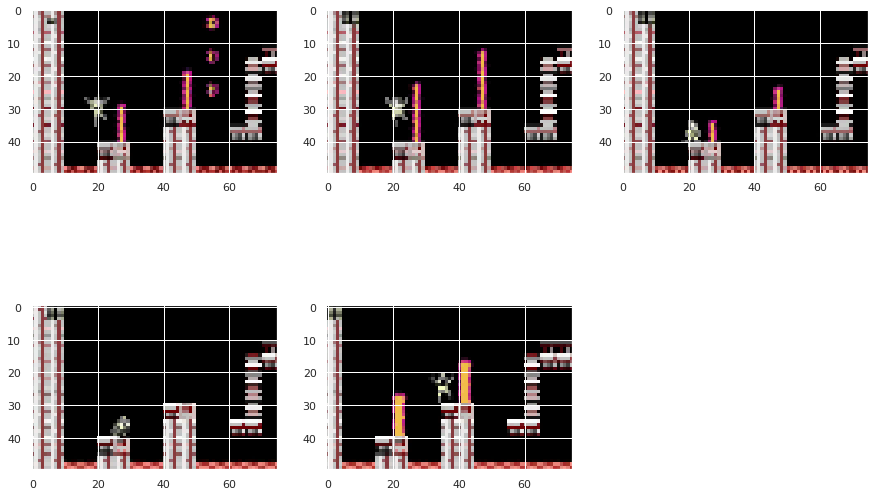

In [142]:
fig = plt.figure( figsize=(15, 10))
sample_images = random.choice(list(X_train))
for sample in range(len(sample_images)):
  axx = fig.add_subplot(2 , 3, sample+1)
  axx.imshow(sample_images[sample], cmap='gray')

## Model Definition

In [143]:
from keras.layers import Concatenate

def inception_module(layer_in, f1, f2, f3, f4, strides):
  alpha=0.1
  # 1x1 conv
  conv1 = keras.layers.Conv2D(f1, (1,1), padding='same', strides=strides,
                              activation='relu', use_bias='True',
                              kernel_regularizer=keras.regularizers.l2(l=alpha)
                              )(layer_in)
  # 3x3 conv
  conv3 = keras.layers.Conv2D(f2, (3,3), padding='same', strides=strides,
                              activation='relu', use_bias='True',
                              kernel_regularizer=keras.regularizers.l2(l=alpha)
                              )(layer_in)
  # 5x5 conv
  conv5 = keras.layers.Conv2D(f4, (5,5), padding='same', strides=strides, 
                              activation='relu', use_bias='True',
                               kernel_regularizer=keras.regularizers.l2(l=alpha)
                              )(layer_in)

  # 7x7 conv
  conv7 = keras.layers.Conv2D(f4, (7,7), padding='same', strides=strides,
                              activation='relu', use_bias='True',
                              kernel_regularizer=keras.regularizers.l2(l=alpha)
                              )(layer_in)
	# concatenate filters, assumes filters/channels last
  layer_out = Concatenate(axis=-1)([conv1, conv3, conv5, conv7])
  return layer_out

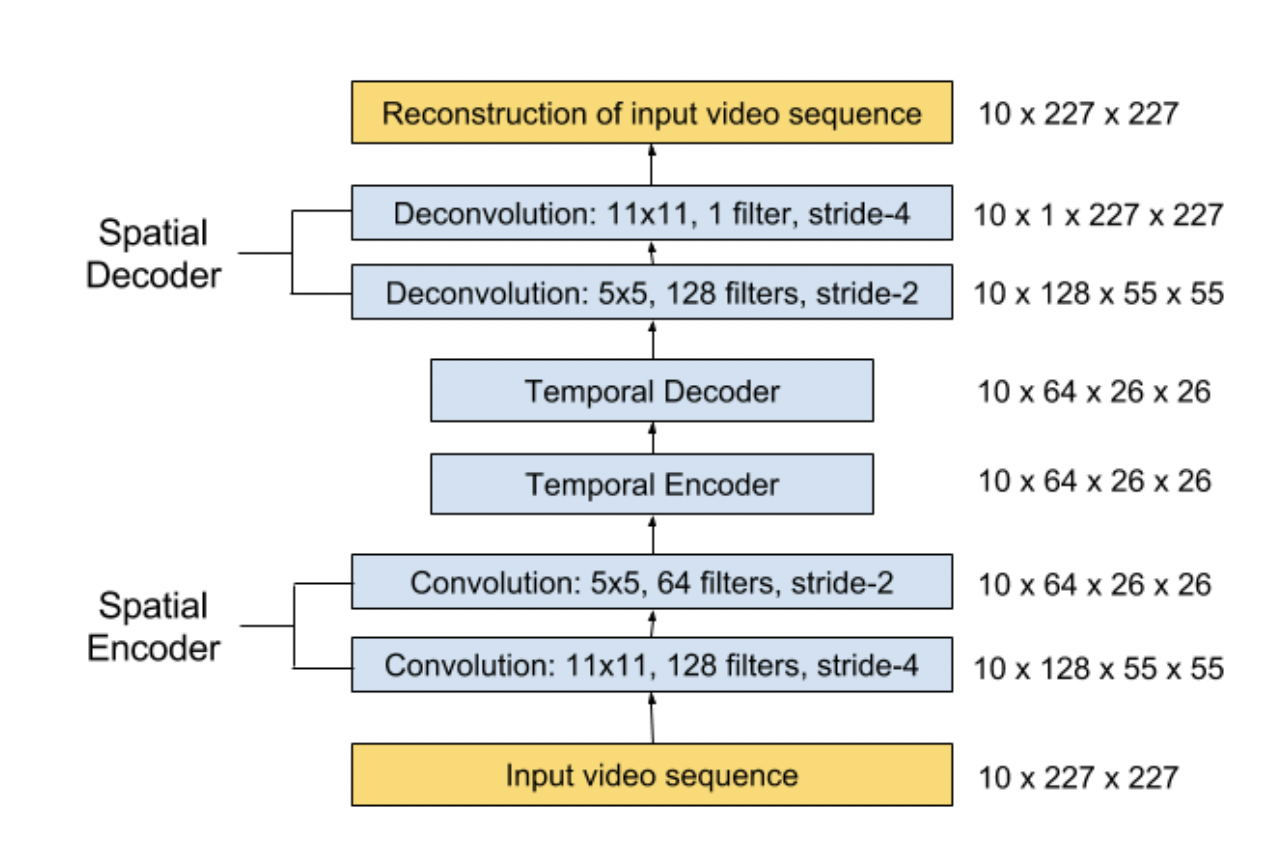

In [144]:
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model

def get_model(reload_model=True):
    seq = Sequential()
    ### Spatial Encoder
    seq.add(TimeDistributed(Conv2D(128, (5, 5), strides=5, padding="same", activation="relu",), 
                            batch_input_shape=(None, WINDOW_SIZE, 50, 75, CHANNELS))
    )
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu")))
    seq.add(LayerNormalization())
    ### Temporal Encoder
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())

    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())

    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    ### Spatial Decoder
    seq.add(TimeDistributed(Conv2DTranspose(64, (3, 3), strides=1, padding="same", activation="relu")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (5, 5), strides=1, padding="same", activation="relu")))
    seq.add(LayerNormalization())

    seq.add(TimeDistributed(Conv2D(num_classes, (5, 5), activation="softmax", padding="same")))
    print(seq.summary())
    return seq

In [145]:
def custom_categorical_loss(y_true, y_pred, sample_weight=None):
    y_true_shape = (tf.shape(y_true).numpy())
    y_true_reshaped = tf.reshape(y_true, [y_true_shape[0]* y_true_shape[1] * y_true_shape[2], num_classes])
    y_pred_reshaped = tf.reshape(y_pred, [y_true_shape[0]* y_true_shape[1] * y_true_shape[2], num_classes])
    cce = tf.keras.losses.CategoricalCrossentropy()
    loss = cce(y_true=y_true_reshaped, y_pred=y_pred_reshaped, sample_weight=sample_weight)
    return loss

## Train the Model

In [146]:
mcp_save = keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')

In [147]:
# Autoencoders
seq = get_model(False)
seq.compile(
    metrics=["categorical_accuracy"], loss=["categorical_crossentropy"],
    optimizer=keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5, epsilon=1e-6)
  )
history = seq.fit(
        x=X_train, y=y_train, validation_data=(X_valid, y_valid), 
        epochs=50, batch_size=128,
        sample_weight=sample_weight
)
seq.save("lstm_model.hdf5")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 5, 10, 15, 128)   9728      
 stributed)                                                      
                                                                 
 layer_normalization_21 (Lay  (None, 5, 10, 15, 128)   256       
 erNormalization)                                                
                                                                 
 time_distributed_16 (TimeDi  (None, 5, 10, 15, 64)    73792     
 stributed)                                                      
                                                                 
 layer_normalization_22 (Lay  (None, 5, 10, 15, 64)    128       
 erNormalization)                                                
                                                                 
 conv_lstm2d_9 (ConvLSTM2D)  (None, 5, 10, 15, 64)    

In [148]:
def plot_accuracies(history):
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('model accuracy per epoch')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  

def plot_losses(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss per epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [149]:
# swq.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4), metrics=["categorical_accuracy"], loss=["categorical_crossentropy"])
# # for i in reversed(range(8)):
#   # history = autoencoder.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid), epochs=16, batch_size=int(math.pow(2, i)), sample_weight=sample_weight, callbacks=[mcp_save])
# history = autoencoder.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid), sample_weight=sample_weight, epochs=75, batch_size=128, callbacks=[mcp_save], shuffle=True)
# plot_losses(history)
# plot_accuracies(history)

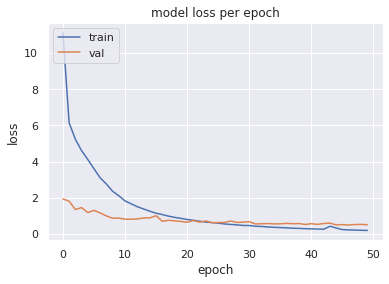

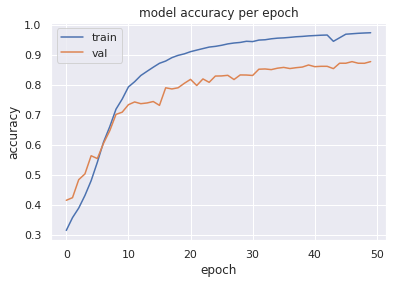

In [150]:
# history = autoencoder.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid), epochs=64, batch_size=64, sample_weight=sample_weight)
plot_losses(history)
plot_accuracies(history)

In [151]:
# Retrain the best model using the entire train and validation data 
autoencoder = keras.models.load_model('.mdl_wts.hdf5')

## Model Evaluation

In [152]:
# Training Accuracy
predictions = seq.predict(X_train)
y_pred_train = tf.one_hot(tf.argmax(predictions, axis=-1), depth = num_classes)
acc = keras.metrics.CategoricalAccuracy()
print(y_train.shape, y_pred_train.shape)
acc.update_state(y_train, y_pred_train)
print("Train acc:", acc.result().numpy())

# Training Accuracy
predictions = seq.predict(X_valid)
y_pred_valid = tf.one_hot(tf.argmax(predictions, axis=-1), depth = num_classes)
acc = keras.metrics.CategoricalAccuracy()
acc.update_state(y_valid, y_pred_valid)
print("Validation acc:", acc.result().numpy())


# Testing Accuracy
predictions = seq.predict(X_test)
y_pred_test = tf.one_hot(tf.argmax(predictions, axis=-1), depth = num_classes)
acc = keras.metrics.CategoricalAccuracy()
acc.update_state(y_test, y_pred_test)
print("Test acc:", acc.result().numpy())

(6527, 5, 10, 15, 9) (6527, 5, 10, 15, 9)
Train acc: 0.976869
Validation acc: 0.8774779
Test acc: 0.6691406


In [153]:
def plot_confusion_matrix(y_pred, y_true_numerical, title="Statistics"):
  letters = list(enc_map.keys())
  y_pred_numerical = (np.argmax(y_pred, axis = -1) + 1).astype('int')

  y_pred_string = np.vectorize(reversed_enc_map.get)(y_pred_numerical)
  y_true_string = np.vectorize(reversed_enc_map.get)(y_true_numerical)

  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cf_matrix = pd.DataFrame(
        confusion_matrix(y_true_string.flatten(),
        y_pred_string.flatten(), labels=letters), 
        index=['{:}'.format(x) for x in letters], 
        columns=['{:}'.format(x) for x in letters]
    )

    print(metrics.classification_report(
        y_true_string.flatten(),
        y_pred_string.flatten(),
        labels=letters)
    )

    from matplotlib.pyplot import figure
    figure(figsize=(10, 6), dpi=80)
    ax = sns.heatmap(cf_matrix, annot=True,cmap='BuPu', fmt='g', xticklabels=True, yticklabels=True)

    ax.set_title(title + "\n\n")
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

    ## Display the visualization of the Confusion Matrix.
    plt.show()

              precision    recall  f1-score   support

           #       0.97      1.00      0.99   1513865
           -       1.00      0.97      0.98   2958338
           D       0.99      0.96      0.97     63490
           H       0.92      0.97      0.94     36933
           M       0.81      1.00      0.90     35847
           B       0.94      0.94      0.94     74170
           S       0.87      0.95      0.91    106857
           |       0.83      0.95      0.89     91124
           O       0.52      1.00      0.68     14626

    accuracy                           0.98   4895250
   macro avg       0.87      0.97      0.91   4895250
weighted avg       0.98      0.98      0.98   4895250



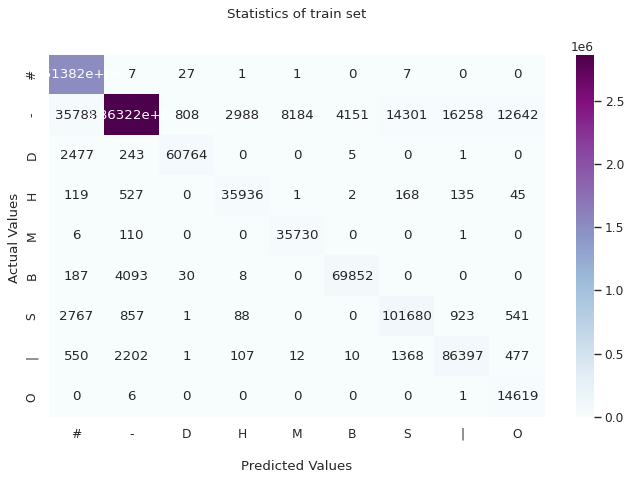

In [154]:
# Evaluate Training Performance
plot_confusion_matrix(
    y_pred_train, y_train_numerical,
    title="Statistics of train set"
)


 Displaying Game-specific stats for ***KID_ICARUS***
              precision    recall  f1-score   support

           #       0.96      1.00      0.98    355058
           -       1.00      0.98      0.99   1101282
           D       0.95      0.91      0.93      5920
           H       0.92      0.99      0.95      8703
           M       0.93      1.00      0.96     26787
           B       0.00      0.00      0.00         0
           S       0.00      0.00      0.00         0
           |       0.00      0.00      0.00         0
           O       0.00      0.00      0.00         0

   micro avg       0.99      0.99      0.99   1497750
   macro avg       0.53      0.54      0.54   1497750
weighted avg       0.99      0.99      0.99   1497750



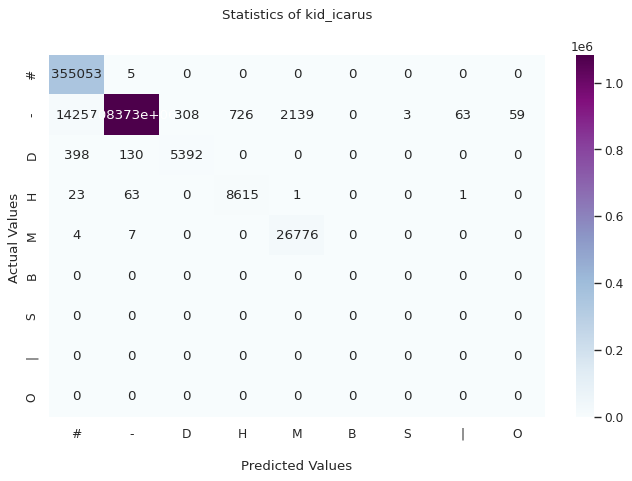


 Displaying Game-specific stats for ***MEGAMAN***
              precision    recall  f1-score   support

           #       0.98      1.00      0.99    481420
           -       1.00      0.98      0.99    938460
           D       0.00      0.00      0.00         0
           H       0.98      0.99      0.99     20435
           M       0.60      0.99      0.75      9060
           B       0.00      0.00      0.00         0
           S       0.94      0.95      0.94      7270
           |       0.97      0.99      0.98     38030
           O       0.76      1.00      0.86      3075

    accuracy                           0.99   1497750
   macro avg       0.69      0.77      0.72   1497750
weighted avg       0.99      0.99      0.99   1497750



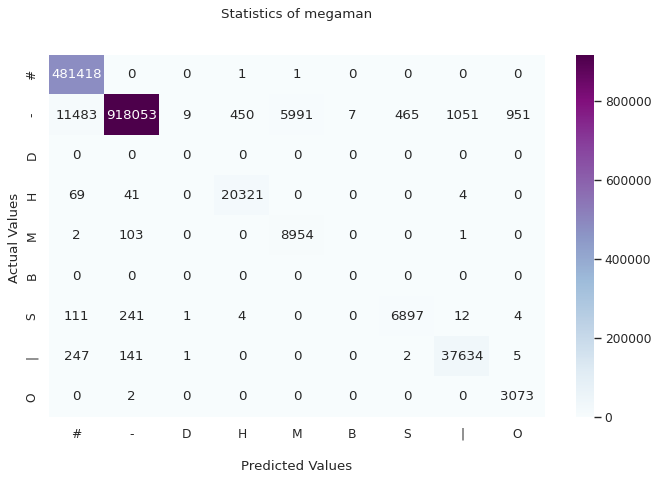


 Displaying Game-specific stats for ***ZELDA***
              precision    recall  f1-score   support

           #       0.98      1.00      0.99    663805
           -       0.99      0.98      0.99    695745
           D       0.99      0.96      0.98     57570
           H       0.96      0.98      0.97      5885
           M       0.00      0.00      0.00         0
           B       0.94      0.94      0.94     74170
           S       0.00      0.00      0.00         0
           |       1.00      0.94      0.97       575
           O       0.00      0.00      0.00         0

   micro avg       0.99      0.99      0.99   1497750
   macro avg       0.65      0.65      0.65   1497750
weighted avg       0.99      0.99      0.99   1497750



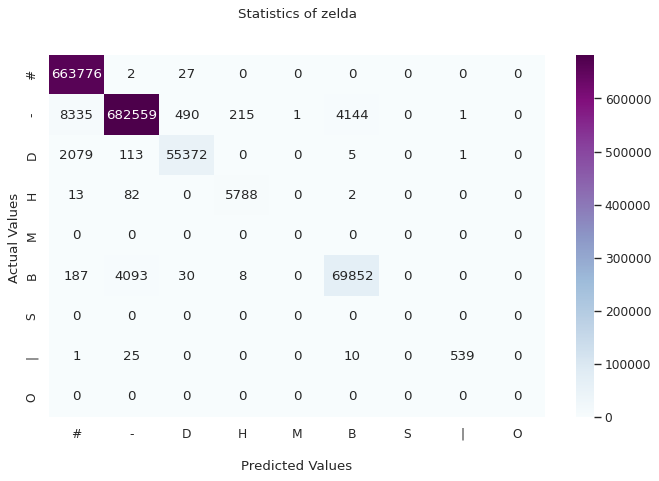


 Displaying Game-specific stats for ***LOAD_RUNNER***
              precision    recall  f1-score   support

           #       0.74      1.00      0.85     13582
           -       0.98      0.80      0.88    222851
           D       0.00      0.00      0.00         0
           H       0.40      0.63      0.49      1910
           M       0.00      0.00      0.00         0
           B       0.00      0.00      0.00         0
           S       0.86      0.95      0.90     99587
           |       0.75      0.92      0.82     52519
           O       0.48      1.00      0.65     11551

   micro avg       0.87      0.87      0.87    402000
   macro avg       0.47      0.59      0.51    402000
weighted avg       0.90      0.87      0.87    402000



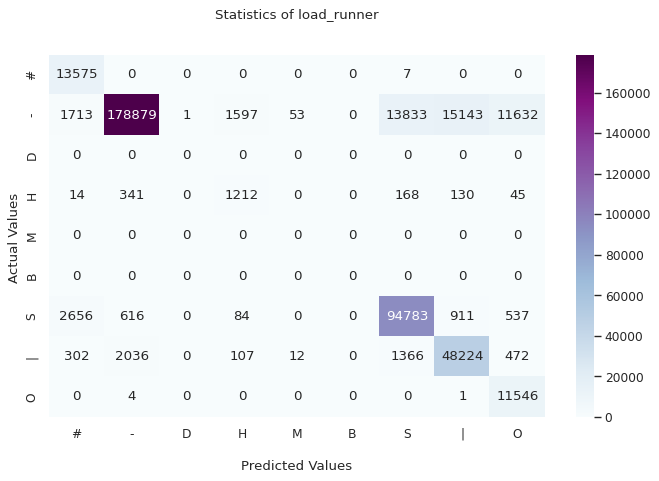

In [155]:
import warnings

def per_game_stats(y_pred_train, y_train_numerical, X_train_frame_names, X_test_frame_names):
  game_based_true = {game_key:[] for game_key in game_keys}
  game_based_pred = {game_key:[] for game_key in game_keys}

  for index, img_seq in enumerate(X_train_frame_names):
    game_part = img_seq[0].split("-")[0]
    game_based_true[game_part].append(y_train_numerical[index])
    game_based_pred[game_part].append(y_pred_train[index])

  for game in list(game_based_true.keys()):
    if game != TEST_GAME:
      print(f"\n Displaying Game-specific stats for ***{game.upper()}***")
      plot_confusion_matrix(
          game_based_pred[game], game_based_true[game],
          title=f"Statistics of {game}"
      )


per_game_stats(y_pred_train, y_train_numerical, X_train_frame_names, X_test_frame_names)

              precision    recall  f1-score   support

           #       0.86      0.95      0.90    164612
           -       0.94      0.86      0.90    235089
           D       0.78      0.63      0.69      5685
           H       0.57      0.41      0.48      3458
           M       0.80      0.79      0.79      7790
           B       0.10      0.16      0.13       990
           S       0.64      0.71      0.67     10312
           |       0.57      0.70      0.63      6551
           O       0.11      0.24      0.15      1263

    accuracy                           0.88    435750
   macro avg       0.60      0.61      0.59    435750
weighted avg       0.89      0.88      0.88    435750



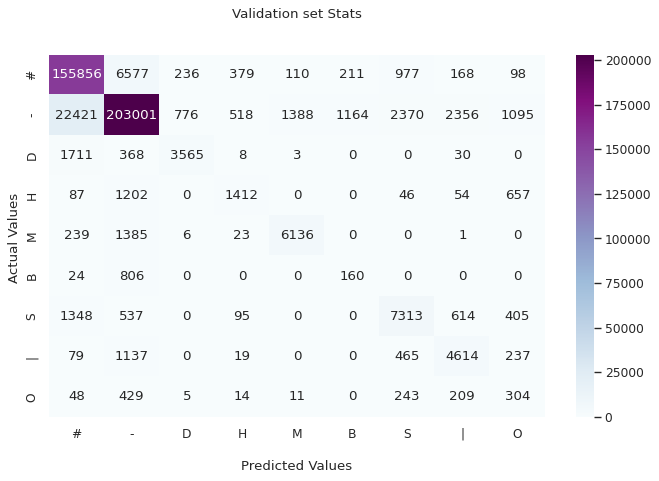

In [156]:
# Evaluate Validation Performance
plot_confusion_matrix(y_pred_valid, y_valid_numerical, title="Validation set Stats")

              precision    recall  f1-score   support

           #       0.22      0.48      0.30    132622
           -       0.91      0.76      0.83    850084
           D       0.13      0.01      0.01     22592
           H       0.00      0.01      0.01     11866
           M       0.00      0.00      0.00         0
           B       0.00      0.00      0.00      5362
           S       0.03      0.01      0.01     28064
           |       0.00      0.00      0.00         0
           O       0.01      0.01      0.01      7660

    accuracy                           0.67   1058250
   macro avg       0.14      0.14      0.13   1058250
weighted avg       0.76      0.67      0.70   1058250



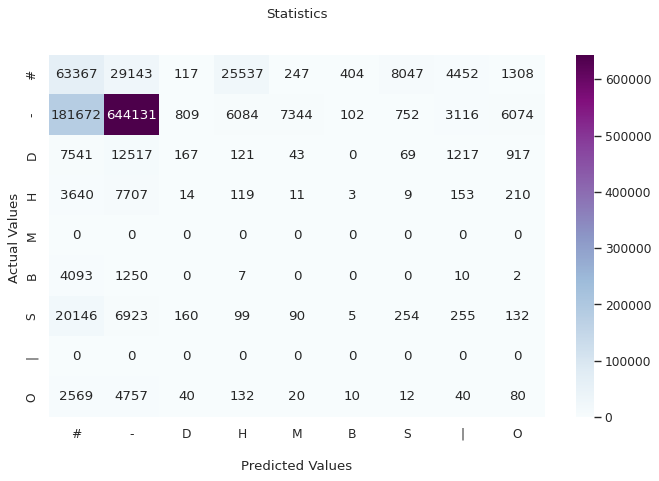

In [157]:
# Evaluate Testing Performance
plot_confusion_matrix(y_pred_test, y_test_numerical)

In [158]:
def plot_random_results(X, y_real_numerical, y_pred):
  y_pred_numerical = (np.argmax(y_pred, axis = -1) + 1).astype('int')

  for i in random.sample(range(len(y_pred)), 10):
    print("Example no:", i)
    print("predicted:" + " " * 20 + "real")
      
    decoded_pred = list(np.vectorize(reversed_enc_map.get)(y_pred_numerical))[i][0]
    decoded_real = list(np.vectorize(reversed_enc_map.get)(y_real_numerical))[i][0]


    for idx, row in enumerate(decoded_pred):
      print("".join(row) + "        " + "".join(decoded_real[idx]))

    plt.imshow(X[i][0])
    plt.show()
    print("\n")
    print("****************************************")

Example no: 1050
predicted:                    real
--------MMMMMMM        ---------------
---------------        ---------------
---------------        ---------------
------##-------        ------#SS--O---
-----SS--O-----        -----###-------
----S|#--##----        ----####-SS----
---S-S#--------        ---#####-------
O-O####---###--        --######--SSS--
OO#####------O#        -#######-------
#|-|##-------|#        #######------##


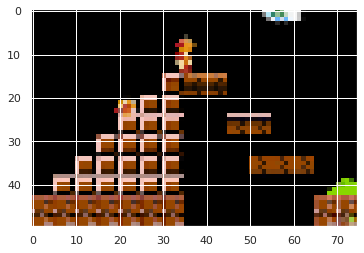



****************************************
Example no: 266
predicted:                    real
##-------####-#        ---------------
##-----------##        ---H-----OO----
#----#--------#        ---------------
#---######---##        #--------------
----#---##----#        ---------------
----########--#        -----####--####
#----#--####--#        ---------------
#---##--------#        ---------------
##---#---###--#        --OOO----------
########D####-#        --###----------


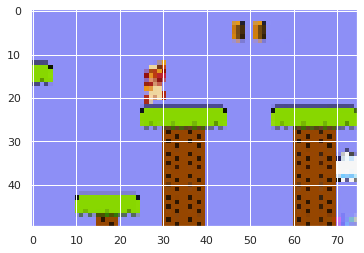



****************************************
Example no: 503
predicted:                    real
-------------#M        ---------------
#--------------        S--------------
---------------        ---------------
-----HH---#----        ----------##---
#--------S#----        S--------###---
-------HS##----        --------####---
-------S-|#----        -------#####---
-----|#####----        ------######---
OO-O-######-OOO        -----#######---
OOO|#######---S        -##########--##


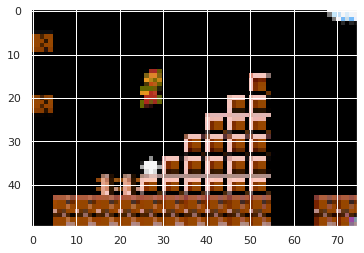



****************************************
Example no: 949
predicted:                    real
######-----####        ---------------
####---------##        -----H-----OO--
###------------        ---------------
####------##--#        ###------------
####--#----#---        ---------------
###---##--####-        -------####--##
###----#--####-        ---------------
###-#------####        ---------------
#####-##---###-        ----OOO--------
#########--####        ----###--------


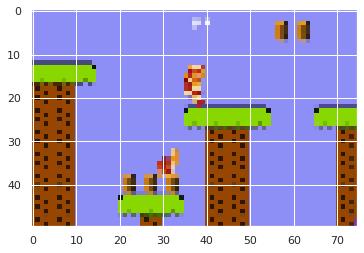



****************************************
Example no: 981
predicted:                    real
-MM-MMM######--        ---------------
---------------        ---------------
---------------        ---------------
---------------        ---------------
---------------        ---------------
-------------HH        ---------------
----------O####        ------------###
------OOH###|--        ---------######
--O-OOS#|###--O        ------#######--
OOOO|######--O-        --#########----


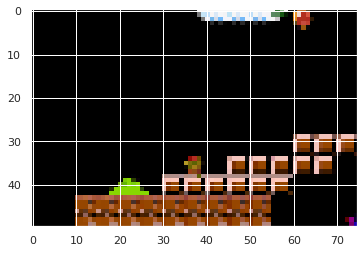



****************************************
Example no: 382
predicted:                    real
###############        ---------------
###############        SSSS---O-------
#---##---##----        ---------------
#--------------        ---------------
#--#-----------        ---------------
##-#--#--------        H-----------H--
#-----#--------        -----H-----DD--
#-------------#        -----------DD--
###-----------#        -----------DDH-
#HHHHHHHH-HH-H#        ###############


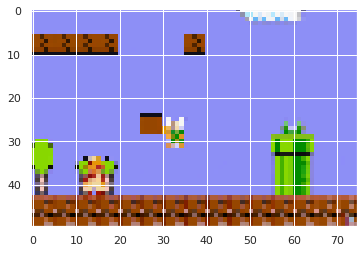



****************************************
Example no: 1376
predicted:                    real
#---------#####        ---------------
##-----#--#####        ---------------
------------###        ---------------
-------------##        ---------------
#-------------#        --------------H
#-------------#        ----------H--DD
------------#-#        ---------DD--DD
--HH-H-----##-#        ---------DD--DD
--##--##---##-#        ---HH-H--DD--DD
#HHHHHHH#|-####        ########-##--##


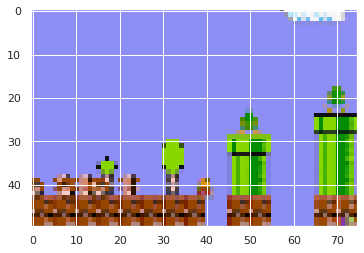



****************************************
Example no: 816
predicted:                    real
-----##########        -----SSSSSSSSSS
-----##########        -----SSSSSSSSSS
-----#---------        -----S---------
-------------MM        -----S---------
-------#---H--H        ------OOOOOOOOO
------#########        ------OOSSSSSSS
-----------D-#-        #--------------
||||-----------        ####-----------
-----####DH##D-        #------------HH
-----##########        -----##########


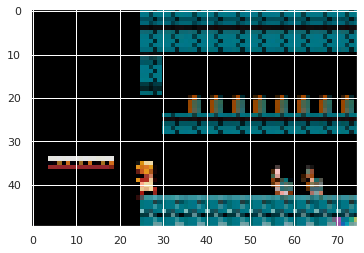



****************************************
Example no: 1282
predicted:                    real
####-##########        ---------------
##########-----        S--------------
---------------        ---------------
#------------##        ---------------
#------#-------        -----------SS--
----##-------##        S--------------
---------------        ---#----H------
#--------------        ---#----H------
--------|----##        ---#----H------
##-H-HHHHHHHH##        ##############-


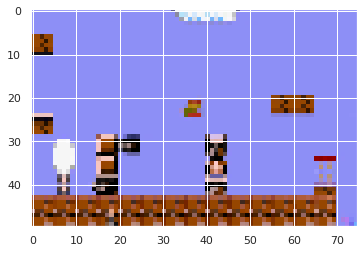



****************************************
Example no: 155
predicted:                    real
-----####--##MM        -------SS--SSSS
-----##--------        -----SS--------
-----##--------        -----SS--------
---------------        -----SS--------
-----#---------        -----SS----OOOO
-----#-##--####        -----SSSS--SSSS
-------##-----#        -------SS------
------###------        -------SS------
###############        ------H------H-
###############        ###############


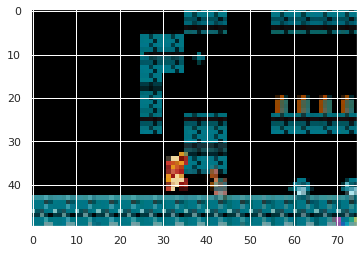



****************************************


In [159]:
## A few random examples from the test set 
plot_random_results(X_test, y_test_numerical, y_pred_test)

Example no: 5003
predicted:                    real
###############        ###############
###############        ###############
##------------#        ##------------#
##------------#        ##------------#
##------------#        ##------------#
##------------#        ##------------#
##------------#        ##------------#
##------------#        ##------------#
##------------#        ##------------#
#######DD######        #######DD######


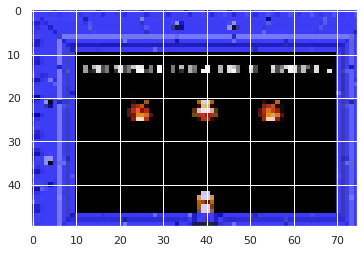



****************************************
Example no: 5873
predicted:                    real
###############        ###############
#######DD######        #######DD######
##------------#        ##------------#
##-H--H--H--H-#        ##-H--H--H--H-#
#D------------#        #D------------#
#D-H--H--H--H-#        #D-H--H--H--H-#
#D------------#        #D------------#
##-H--H--H--H-#        ##-H--H--H--H-#
##-#-----#----#        ##------------#
#######DD######        #######DD######


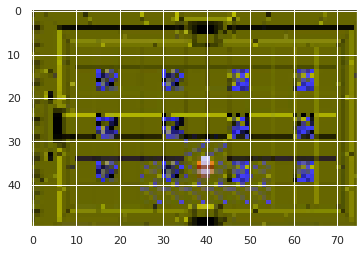



****************************************
Example no: 2292
predicted:                    real
---|--------###        ---|--------###
---#####----###        ---#####----###
------------###        ------------###
------------###        ------------###
---#|##########        ---#|##########
----|-------###        ----|-------###
----|-------###        ----|---------#
----|---------#        ----|---------#
----|---------#        ----|---------#
---#####-####|#        ---####--####|#


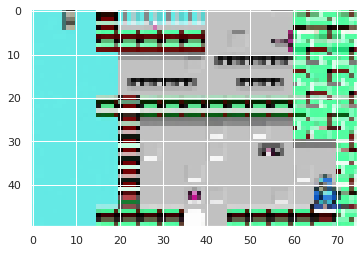



****************************************
Example no: 3578
predicted:                    real
---------------        ---------------
---------------        ---------------
---------------        ---------------
---------------        ---------------
#-----------###        #------------##
#------------##        #------------##
###--------####        ###--------####
###--------####        ###--------####
###############        ###############
###############        ###############


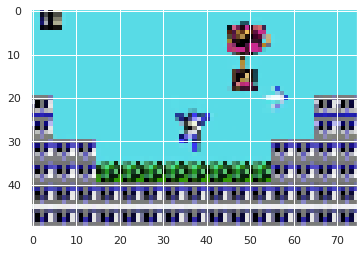



****************************************
Example no: 2268
predicted:                    real
----------#####        ----------#####
--------#######        --------#######
--------#######        --------#######
------#########        ------#########
--|#--#########        --|#--#########
--|#----------#        --|#----------#
--|-----------#        --|-----------#
--|-----------#        --|-----------#
--|-----------#        --|-----------#
##|#######-##|#        ##|#######--#|#


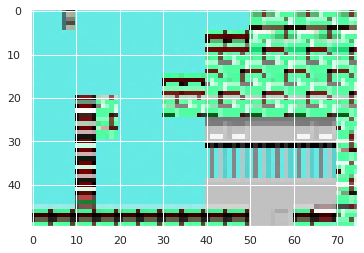



****************************************
Example no: 3613
predicted:                    real
#########----##        #########----##
#########----##        #########----##
######----##-##        ######----##-##
######----##-##        ######----##-##
-------##-#####        -------##-#####
-------##-#####        -------##-#####
----##-##H#####        ----##-##H#####
----###########        ----##-########
######H########        ######H########
###############        ###############


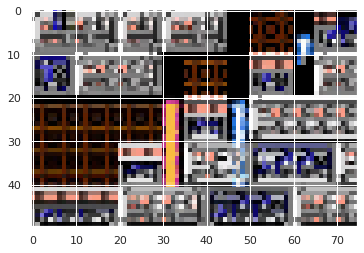



****************************************
Example no: 4851
predicted:                    real
###############        ###############
###############        ###############
##H----------H#        ##H----------H#
##------------#        ##------------#
#D------------#        #D------------#
#D------------#        #D------------#
#D------------#        #D------------#
##------------#        ##------------#
##H----------H#        ##H----------H#
###############        ###############


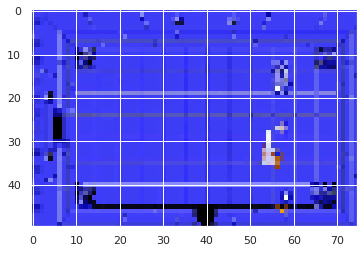



****************************************
Example no: 5600
predicted:                    real
###############        ###############
##------------#        ##------------#
##------------#        ##------------#
#D------------#        #D------------#
#D------------#        #D------------#
#D------------#        #D------------#
##------------#        ##------------#
##------------#        ##------------#
#######DD######        #######DD######
###############        ###############


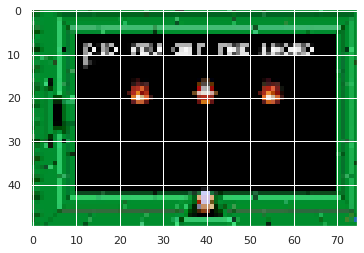



****************************************
Example no: 4256
predicted:                    real
###############        ###############
###############        ###############
##------------#        ##------------#
##------------#        ##------------#
##------------D        ##------------D
##-----------#D        ##------------D
##------------D        ##------------D
##------------#        ##------------#
##------------#        ##------------#
###############        ###############


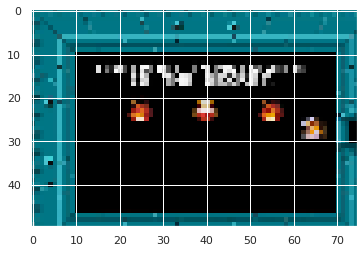



****************************************
Example no: 1868
predicted:                    real
---------------        ---------------
------####-----        ------####-----
---------------        ---------------
-----#---####--        ---------####--
---------------        ---------------
####--------###        ####--------###
-----H-------M-        -----H---------
----###--------        ----###--------
---------------        ---------------
------####-----        ------####-----


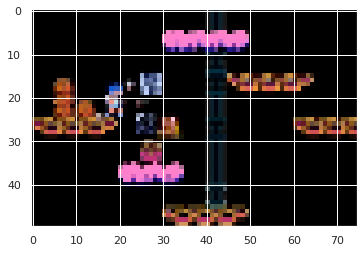



****************************************


In [160]:
## A few random examples from the training set 
plot_random_results(X_train, y_train_numerical, y_pred_train)

Example no: 444
predicted:                    real
###############        ###############
######--D######        #######DD######
###----------##        #######--######
##---------#--#        ###---#----#-##
#D#---#-##-#---        #D#-#-#-##-#-#D
#D#-#|#--#-#---        #D--#-#--#-#--D
#D###|##-#-####        #D#-#-##-#-#-#D
###-#|#########        ###-#----#---##
#######--######        #######--######
########D######        ###############


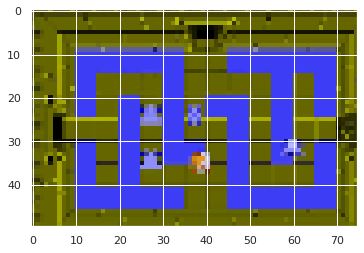



****************************************
Example no: 65
predicted:                    real
---------------        ---------------
---------####--        ---------####--
---------------        ---------------
---------#----#        ---------------
-------M#-##-##        MMMMMMMMMMMMMMM
---------------        ---------------
-----------#---        ---------------
-####------#--M        -####----------
-------------M-        ---------------
--#----------##        ---------------


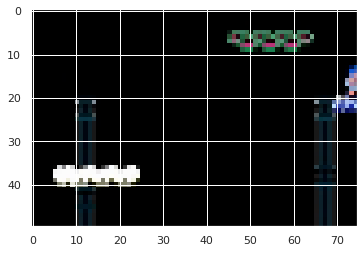



****************************************
Example no: 127
predicted:                    real
-M---MM----####        ------------###
---------------        ---------------
-M--M---###----        --------###----
------------##-        ---------------
------#-----##-        ---------------
###---#----####        ###---------###
----MMMMM---###        ---------------
--------#-#####        ------------###
|###-----------        ####-----------
-###-----------        ---------------


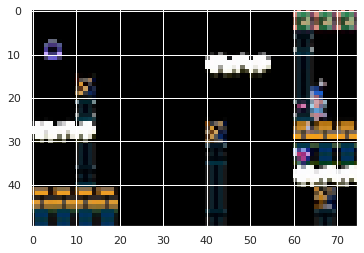



****************************************
Example no: 260
predicted:                    real
##------#-----#        ##------SS-----
##------#H----#        ##------SS-----
##------#-----#        ##------SS-----
##----------S##        ##-------------
##------------#        ##-------------
##|############        ##|############
##|####-#######        ##|############
##|############        ##|############
##|############        ##|############
##|############        ##|############


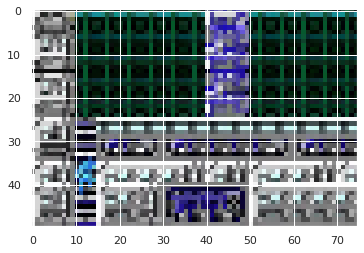



****************************************
Example no: 292
predicted:                    real
###############        ###############
###############        ###############
##-##--##--###-        ###############
#--##--##--##--        #--##--##--##--
---------------        ---------------
---------------        ---------------
---------------        ---------------
---------------        ---------------
#--##--##--##--        #--##--##--##--
###############        ###############


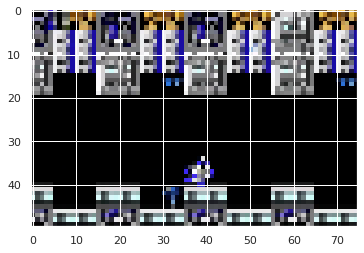



****************************************
Example no: 475
predicted:                    real
####-##########        ###############
########D######        #######DD######
#######---#####        ##------------#
##-#B#-DH-#####        ##-###----###-#
##--H--D####H-#        ##-#--------#-D
##-HH#######|##        ##-#-######-#-D
##-B-#--#####-#        ##-#--------#-D
##-H------#---#        ##-###----###-#
##-------###|-#        ##------------#
########D######        #######DD######


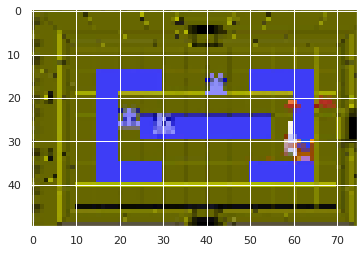



****************************************
Example no: 118
predicted:                    real
---------------        ---------------
--------------#        ------------###
####--------###        ####-----------
----------#####        ----------#####
-------####----        -------####----
M------####----        -------####----
---------------        ---------------
-####-------OO#        -####--------##
#####-MMM-MM###        ##----------###
-------------##        ---------------


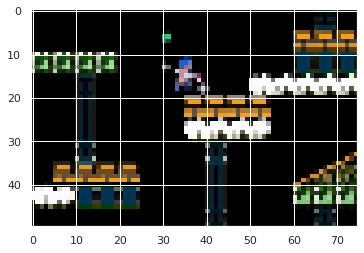



****************************************
Example no: 215
predicted:                    real
###############        ###############
###############        ###############
##-#----#------        ---------------
#--------------        ---------------
---------------        ---------------
####-#---#####-        ---------------
###############        ###############
###############        ###############
###############        ###############
###############        ###############


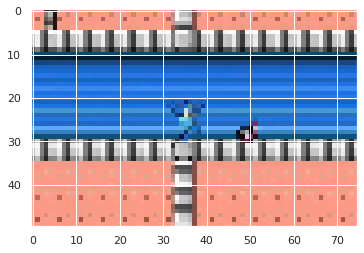



****************************************
Example no: 547
predicted:                    real
------|--------        ------|--------
------|--------        ------|--------
------|O-------        ------|O---O---
------|----|---        ------|--------
------|O-------        ------|--------
------|----HHSS        ------|-----SSS
------|--SSSSSS        ------|--SSSSSS
------|---SSSSS        ------|---SSSSS
M-----|O||SSSSS        ------|----SSSS
------|O||OSSSS        ------|------SS


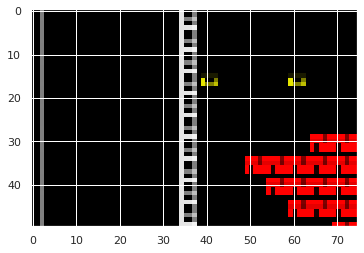



****************************************
Example no: 80
predicted:                    real
---------######        ---------######
---------------        ---------------
------####-----        ------####-----
---------------        ---------------
---####--------        ---####--------
--------------#        --------------H
####--------###        ####--------###
---------------        ---------------
----#---#####--        ---------####--
----#-#-#------        ---------------


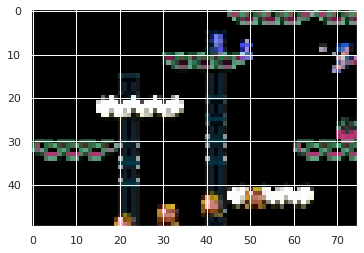



****************************************


In [161]:
## A few random examples from the validation set 
plot_random_results(X_valid, y_valid_numerical, y_pred_valid)

In [174]:
def find_nearest(array, value):
    array = np.asarray(array)
    arr = np.abs(array - value)
    subtracted = np.apply_over_axes(np.sum, arr, [1, 2, 3])
    print(subtracted.shape)
    idx = subtracted.argmin()
    return array[idx]

In [175]:
import difflib
def plot_random_similars(X, y_test_numerical, y_pred_train, y_pred):
  y_pred_train_numerical = (np.argmax(y_pred_train, axis = -1) + 1).astype('int')
  y_pred_train_one_hot = keras.utils.to_categorical(y_pred_train_numerical - 1, num_classes)
  y_pred_numerical = (np.argmax(y_pred, axis = -1) + 1).astype('int')

  for i in random.sample(range(len(y_pred)), 10):
    print("Example no:", i)
    print("sample:" + " " * 15 + " " + "predicted:" + " "*13 + "closest:")
    all_samples = [list(seq[0]) for seq in y_pred_train_one_hot]

    most_similar = find_nearest(all_samples, keras.utils.to_categorical(y_pred_numerical[i][0] - 1, num_classes))

    decoded_sample = list(np.vectorize(reversed_enc_map.get)(y_test_numerical))[i][0]
    decoded_pred = list(np.vectorize(reversed_enc_map.get)(y_pred_numerical))[i][0]
    decoded_similar = list(np.vectorize(reversed_enc_map.get)((np.argmax(most_similar, axis = -1) + 1).astype('int')))


    for idx, row in enumerate(decoded_pred):
      print("".join(decoded_sample[idx]) + "        " + "".join(row) + "        " + "".join(decoded_similar[idx]))

    plt.imshow(X[i][0])
    plt.show()
    print("\n")
    print("****************************************")

Example no: 197
sample:                predicted:             closest:
(6527, 1, 1, 1)
---------###---        --------###----        ---------#-#---
---------------        --------------M        ---------------
---------------        -------------M-        ---------------
---------------        ---------------        ---------------
--------------S        -----#--------#        ---------------
-----###-------        -----#---------        ---------------
----H###-###---        -----##-------D        ---------------
--H#####-------        ---#####------|        ---------------
--######-------        ########------#        ###############
#######-------#        #######-HHHH--#        ###########---#


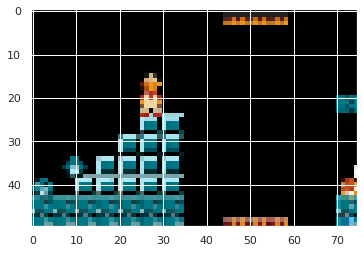



****************************************
Example no: 1024
sample:                predicted:             closest:
(6527, 1, 1, 1)
---------------        -####----------        #####----------
---------------        ---------------        ---------------
---------------        ---------------        ---####--------
---------------        ---------------        ---------------
----#SS-SB-----        ----###-##-----        ------####-----
---###---------        ---S#----------        ---------------
--####---------        ---S#----------        ---------####--
-#####---------        -|###-----OOH--        ------------#--
######--SSSSS--        O####---SSSSOO-        ####--------###
#####-------##-        |--#-------OOO-        ---#-----------


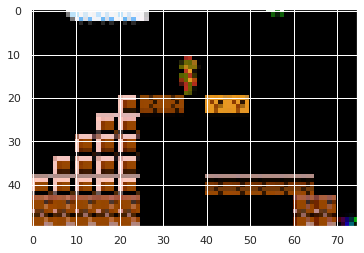



****************************************
Example no: 504
sample:                predicted:             closest:
(6527, 1, 1, 1)
---------------        -----------####        -----------#---
---------------        ---------------        ---------------
---------------        ---------------        ---------------
--------##-----        --------#------        ---------------
-------###-----        -------S#------        ---------------
------####-----        -----|H##------        ---------------
-----#####-----        -----S-|S------        ---------------
----######-----        -OO|H####-----|        ---------------
---#######-----        OO--#|###---OH|        ###############
#########--####        ##H###-##--OS|#        #########-----#


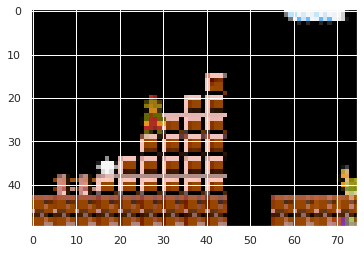



****************************************
Example no: 893
sample:                predicted:             closest:
(6527, 1, 1, 1)
OO----------###        ####--##-######        #######--------
###------------        ####-------##--        #######--------
---------------        ####------###--        #############--
---------------        ####--##---##--        #############--
-------#####---        ####--#######--        #############--
####-----------        ####--#######--        #############--
---------------        ##########D##--        #############--
-----O---------        ####--###--##--        #############--
----###--------        ##########-####        ###############
---------------        #####|D###-D##-        ###############


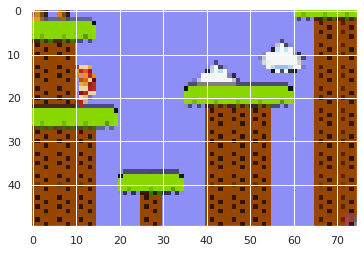



****************************************
Example no: 1196
sample:                predicted:             closest:
(6527, 1, 1, 1)
---------------        ##----------MMM        ##-------------
---------------        ##-------------        ##-------------
---------------        -#-------------        ##-------------
---------------        ##-------------        ##-------------
-----####------        -#---###-------        ##-------------
---------------        -#----#--------        ##-------------
######---------        ####--#--------        ##-------------
---------------        -###--#--------        ##-------------
---------------        -###--#--##----        ###-----------#
--------#######        -###--#-####|##        ###############


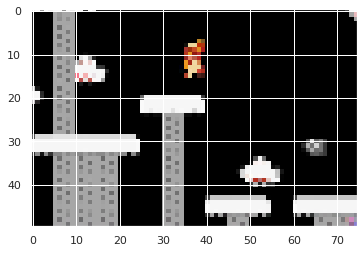



****************************************
Example no: 513
sample:                predicted:             closest:
(6527, 1, 1, 1)
H--------------        ##---H--MMMMMMM        ---------#-#---
BS--SBS--------        ##--###--------        ---------------
---------------        ---------------        ---------------
---------------        -------#-------        ---------------
---------------        ---------------        ---------------
BS--SOS--------        #----#---------        ---------------
------------H--        #--------------        ---------------
---------------        OO-|--|---H---#        ---------------
---H-----------        SOOOOO|#O-O--H#        ###############
###############        |##|#######---#        ###########---#


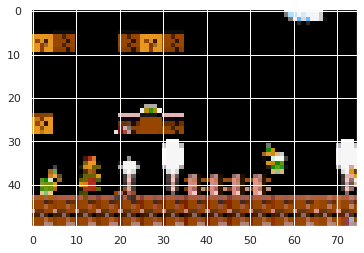



****************************************
Example no: 229
sample:                predicted:             closest:
(6527, 1, 1, 1)
-----OOOO------        #####----#--###        ###############
-----####------        ###############        ###############
---------------        ###########----        ---####--------
---------------        ---|##---------        ---####--------
---------------        ---####--------        ---D##D------B-
---------------        ---######------        ---D##D-----B--
####O----------        ---######------        ---D##D--------
---------------        ---####-#----##        ---####--------
---------------        #--##---------#        ---####-------B
----#####-#####        ###############        ###############


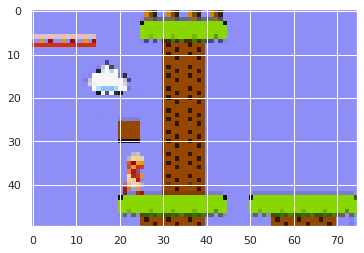



****************************************
Example no: 1221
sample:                predicted:             closest:
(6527, 1, 1, 1)
---------------        ----#--------M|        ---------------
---####--------        --####------MM|        ---------------
---------------        ----#--MMM----|        ---------------
---------------        -H--#---------|        ---------------
---------------        --M-#--------M|        ---------------
---------------        ----#-------MM|        ---------------
---------------        ----#---------M        ---------------
---------------        ----#---------#        ---------------
--------------#        ----#-------###        ------------###
-------########        ----#--########        ----###########


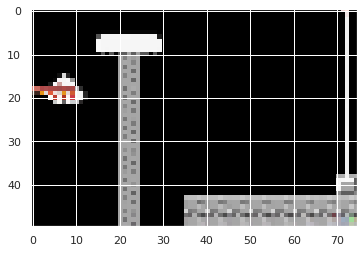



****************************************
Example no: 1285
sample:                predicted:             closest:
(6527, 1, 1, 1)
---------------        ####------#####        ####--------###
---------------        ####---------##        ---------------
-------SS------        #-----######--#        ---------------
------------#--        #---######-----        -----####------
---SS------##--        -----###---BH#H        --------------#
----------###--        #--####---SSH#H        ####--------###
H--------####--        -----#--#-SS###        ------------###
H-------#####--        #-H--HHHHHHHHH#        -----------####
H------######--        -----#--B-B--##        -------########
######-########        ----#--########        ------#########


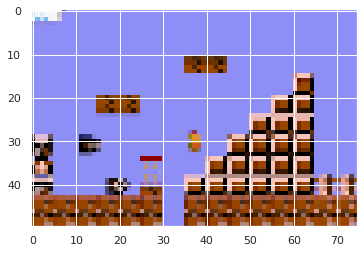



****************************************
Example no: 1316
sample:                predicted:             closest:
(6527, 1, 1, 1)
---------------        ####------#####        #--------------
---------------        ######-------#-        #--------------
---------------        #--------------        #--------------
---------------        #--------------        #--------------
---H-----------        #--#-----------        #--------------
--DD-----------        #--##-#--------        #--------------
--DD-----------        #-|####--------        #--------------
--DD-----------        #--------------        #--------------
--DD----H-H----        #H---#-H-----##        ###------------
#############-#        #H-#H#HHHHHHH##        ###HHHHHHHHHHHH


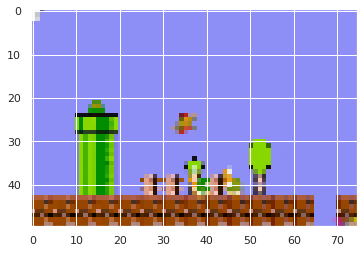



****************************************


In [177]:
plot_random_similars(X_test, y_test_numerical, y_pred_train, y_pred_test)